In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score as accuracy

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

import spacy
nlp = spacy.load('en_core_web_sm')

from sklearn.decomposition import PCA

from tqdm.auto import tqdm

colors = sns.color_palette("rocket")
colors

[(0.20973515, 0.09747934, 0.24238489),
 (0.43860848, 0.12177004, 0.34119475),
 (0.67824099, 0.09192342, 0.3504148),
 (0.8833417, 0.19830556, 0.26014181),
 (0.95381595, 0.46373781, 0.31769923),
 (0.96516917, 0.70776351, 0.5606593)]

In [78]:
df = pd.read_csv('/Users/nazarlenisin/Desktop/Topic Classification/medium_data.csv')
df.head(3)

,id,url,title,subtitle,claps,responses,reading_time,publication,date
0,1,https://towardsdatascience.com/not-all-rainbow...,Not All Rainbows and Sunshine: The Darker Side...,Part 1: The Risks and Ethical Issues…,453.0,11,9,Towards Data Science,27-01-2023
1,2,https://towardsdatascience.com/ethics-in-ai-po...,Ethics in AI: Potential Root Causes for Biased...,An alternative approach to understanding bias ...,311.0,3,12,Towards Data Science,27-01-2023
2,3,https://towardsdatascience.com/python-tuple-th...,"Python Tuple, The Whole Truth and Only the Tru...",NaN,188.0,0,24,Towards Data Science,27-01-2023


In [79]:
class Prior_Data_Analys:
  def __init__(self,df):
    self.df = df


  def shape(self):
    n_samples,n_columns = self.df.shape
    print(f'Number of samples in Data Set: {n_samples}')
    print(f'Number of columns: {n_columns}')

    return n_samples,n_columns


  def unique_columns(self):
    columns = self.df.columns
    print(f'Unique columns:\n')

    for column_idx,column in enumerate(columns):
      print(f'Column {column_idx + 1}: {column}')

    return columns


  def columns_dtypes(self):
    dtypes = self.df.dtypes
    print(f'Dtypes:\n\n {dtypes}')

    return dtypes


  def categorical_features(self):
    print(f'Categorical features:\n')
    categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']

    for feature in categorical_feats:
      print(f'* {feature}')

    return np.array(categorical_feats)


  def numerical_features(self):
    print(f'Numerical features: \n')

    numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']
    for feature in numerical_feats:
      print(f'* {feature}')

    return np.array(numerical_feats)


  def group_by(self,feature):
    categorical = self.categorical_features()

    if feature in categorical:
      return df.groupby([feature]).count()

    else:
      return df.groupby([feature]).describe()


  def count_NA(self):
    print(f'Amout of Nans per class:')
    return self.df.isna().sum()


  def duplicates(self):
    print(f'Amount of duplicates: {self.df.duplicated().sum()}')

  def item(self,index):
    print(f'Object number: {index}')

    return self.df.iloc[index]

  def unique_values(self,feature):
    data = self.df[feature]

    values = data.values
    unique_values = np.unique(values)
    print(f'Unique values of {feature}: {unique_values}')

    return unique_values

In [80]:
class Distribution:
  def __init__(self,df,target_feature):
    self.df = df
    self.target_feature = target_feature
    self._eda = Prior_Data_Analys(self.df)


  def distribution_of_target_feature(self):
    for visualization in range(2):
      plt.figure(figsize = (10,10))
      plt.subplot(2,1,visualization + 1)
      if visualization == 0:
        sns.histplot(data = self.df,x = self.target_feature,color = colors[3])
        plt.title(f'Distribution of Target feature: {self.target_feature}')
        plt.show()

      else:
        sns.boxplot(x = self.df[self.target_feature],color = colors[3])
        plt.title(f'Distribution of Target feature: {self.target_feature}')
        plt.show()


  def distribution_of_numerical_features(self):
    numerical_features = self._eda.numerical_features()

    for feature_idx,feature in enumerate(numerical_features):
      plt.figure(figsize = (15,15))
      plt.subplot(len(numerical_features) // 2 + 1 , 2 , feature_idx + 1)
      sns.histplot(data = self.df,x = feature,color = colors[1])
      plt.title(f'Distibution of {feature}')
      plt.tight_layout
      plt.show()


  def distribution_of_categorical_features(self,top_k = 5):
    categorical_features = self._eda.categorical_features()
    plt.figure(figsize = (20,20))

    for feature_idx,feature in enumerate(categorical_features):

      values = self._eda.group_by(feature)[self.target_feature].sort_values(ascending = False).values[:top_k]
      labels = self._eda.group_by(feature)[self.target_feature].sort_values(ascending = False).index[:top_k]

      data_dict = {'Labels': labels, 'Values': values}
      data = pd.DataFrame(data_dict)

      plt.subplot(len(categorical_features) // 2 + 1 , 2 , feature_idx + 1)
      sns.barplot(data = data,y = 'Labels',x = 'Values',color = colors[-1])
      plt.title(f'Top {top_k} {feature} by count')

    plt.tight_layout()
    plt.show()

  def relation_numerical_feats_to_target_feat(self):
    numerical_features = self._eda.numerical_features()

    data = df[numerical_features]
    corr = data.corr()

    return sns.heatmap(corr,annot = True, cmap = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True))

  def relation_categorical_feats_to_target_feat(self,top_k = 3):
    categorical_features = self._eda.categorical_features()
    plt.figure(figsize = (20,20))

    for feature_idx,feature in enumerate(categorical_features):

      feats = self._eda.group_by(feature)[self.target_feature].sort_values(ascending = False)[:top_k].index

      data = self.df
      data = data[data[feature].isin(feats)]

      plt.subplot(len(categorical_features) // 2 + 1 , 2 , feature_idx + 1)
      sns.stripplot(data = data, x = feature, y = self.target_feature,hue = feature)
      plt.title(f'Relation between {feature} (top {top_k}) & {self.target_feature}')

    plt.tight_layout()
    plt.show()

In [81]:
class Text_Tokenization:
  def __init__(self,nlp,tokenizer):
    self.nlp = nlp
    self.tokenizer = tokenizer

  def _spacy_tokenizer(self,doc):
    return [token.lemma_ for token in self.nlp(doc) if
            not token.is_space]

  def _text_preprocessing(self,doc):
    doc = self._spacy_tokenizer(doc)

    return '|'.join(doc)

  def tokenize(self,doc,max_len,fit = False):
    doc = [self._text_preprocessing(text) for text in doc]

    if fit:
      self.tokenizer.fit_on_texts(doc)

    tokenized_doc = self.tokenizer.texts_to_sequences(doc)
    output = tf.keras.utils.pad_sequences(tokenized_doc,max_len,padding = 'post',truncating = 'post')

    return output

In [82]:
class Publication_rnn(tf.keras.Model):
  def __init__(self,vocab_size,embedding_size,hidden_size,n_classes):
    super().__init__()
    self.vocab_size = vocab_size
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size
    self.n_classes = n_classes

    self.embedding = tf.keras.layers.Embedding(vocab_size,embedding_size,mask_zero = True)
    self.rnn = tf.keras.layers.SimpleRNN(hidden_size,return_sequences = True)

    self.flatten = tf.keras.layers.Flatten()

    self.linear_1 = tf.keras.layers.Dense(64,activation = 'sigmoid')
    self.linear_2 = tf.keras.layers.Dense(128,activation = 'sigmoid')
    self.linear_3 = tf.keras.layers.Dense(n_classes,activation = 'softmax')

  def call(self,X):
    X = self.embedding(X)

    output = self.rnn(X)

    output = self.flatten(output)

    output = self.linear_1(output)
    output = self.linear_2(output)
    output = self.linear_3(output)

    return output

In [83]:
class Publication_lstm(tf.keras.Model):
  def __init__(self,vocab_size,embedding_size,hidden_size,n_classes):
    super().__init__()
    self.vocab_size = vocab_size
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size
    self.n_classes = n_classes

    self.embedding = tf.keras.layers.Embedding(vocab_size,embedding_size,mask_zero = True)
    self.lstm = tf.keras.layers.LSTM(hidden_size,return_sequences = True)

    self.flatten = tf.keras.layers.Flatten()

    self.linear_1 = tf.keras.layers.Dense(64,activation = 'sigmoid')
    self.linear_2 = tf.keras.layers.Dense(128,activation = 'sigmoid')
    self.linear_3 = tf.keras.layers.Dense(n_classes,activation = 'softmax')

  def call(self,X):
    X = self.embedding(X)

    output = self.lstm(X)

    output = self.flatten(output)

    output = self.linear_1(output)
    output = self.linear_2(output)
    output = self.linear_3(output)

    return output

In [84]:
class Train_Model:
  def __init__(self,model,lr,batch_size,epochs):
    self.model = model
    self.lr = lr
    self.batch_size = batch_size
    self.epochs = epochs

  def fit(self,X_train,y_train):
    model = self.model

    model.compile(
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
        optimizer = tf.keras.optimizers.Adam(learning_rate = self.lr),
        metrics = ['accuracy']
    )

    print(f'Metrics on Train Data:')
    model.fit(X_train,y_train,batch_size = self.batch_size,epochs = self.epochs)
    self.model = model

    return model

  def eval(self,X_test,y_test):
    model = self.model

    print(f'\nMetrics on Test Data:')
    model.evaluate(X_test,y_test)

In [103]:
def Publication(model,review):
  tokenized_review = tokenization.tokenize([review],max_len)

  prediction = model(tokenized_review)

  label = np.array(tf.argmax(prediction))[0]
  publication = publications[label]
  print(f'Review: {review} - Publication: {publication}')

In [86]:
df['text'] = df.title.astype('str') + df.subtitle.astype('str')
df = df[['text','publication']]

publications = df['publication'].unique()

In [87]:
df = df.replace(to_replace = 'Towards Data Science', value = 0)
df = df.replace(to_replace = 'UX Collective', value = 1)
df = df.replace(to_replace = 'The Startup', value = 2)
df = df.replace(to_replace = 'The Writing Cooperative', value = 3)

In [88]:
target_feature = 'publication'

eda = Prior_Data_Analys(df)
data_visualization = Distribution(df,target_feature)

In [89]:
eda.shape()

Number of samples in Data Set: 2498
Number of columns: 2


(2498, 2)

In [90]:
eda.unique_columns()

Unique columns:

Column 1: text
Column 2: publication


Index(['text', 'publication'], dtype='object')

In [91]:
eda.columns_dtypes()

Dtypes:

 text           object
publication     int64
dtype: object


text           object
publication     int64
dtype: object

In [92]:
eda.categorical_features()

Categorical features:

* text


/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_36849/4263177674.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_36849/4263177674.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']


array(['text'], dtype='<U4')

In [93]:
eda.numerical_features()

Numerical features: 

* publication


/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_36849/4263177674.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_36849/4263177674.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']


array(['publication'], dtype='<U11')

In [94]:
eda.count_NA()

Amout of Nans per class:


text           0
publication    0
dtype: int64

In [95]:
eda.duplicates()
df = df[df.duplicated() == False]

Amount of duplicates: 649


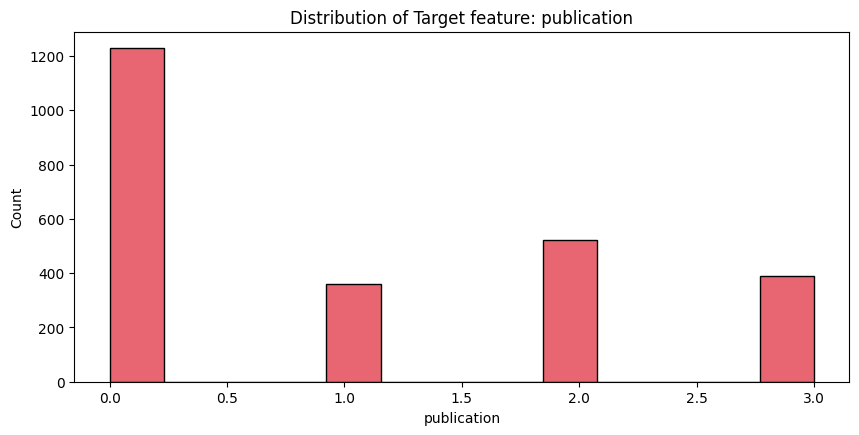

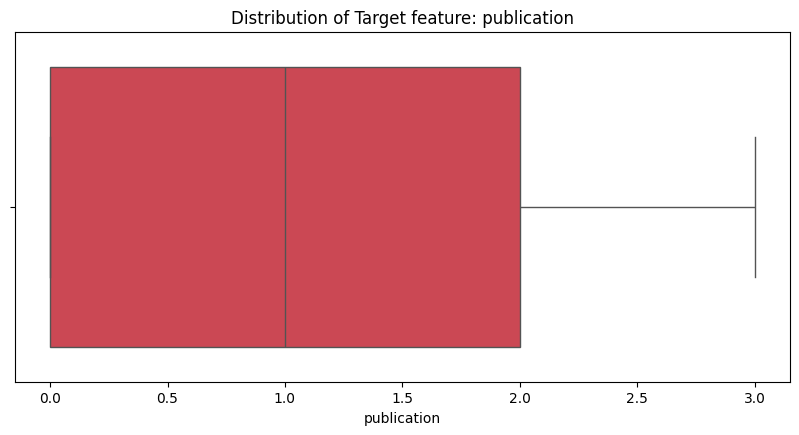

In [96]:
data_visualization.distribution_of_target_feature()

In [97]:
X = df['text'].values
y = df['publication'].values

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

In [98]:
max_len = 80

tokenizer = Tokenizer(split = '|',oov_token = '<unk>')
tokenization = Text_Tokenization(nlp,tokenizer)

X_train = tokenization.tokenize(X_train,max_len,True)
X_test = tokenization.tokenize(X_test,max_len)

vocab = tokenization.tokenizer

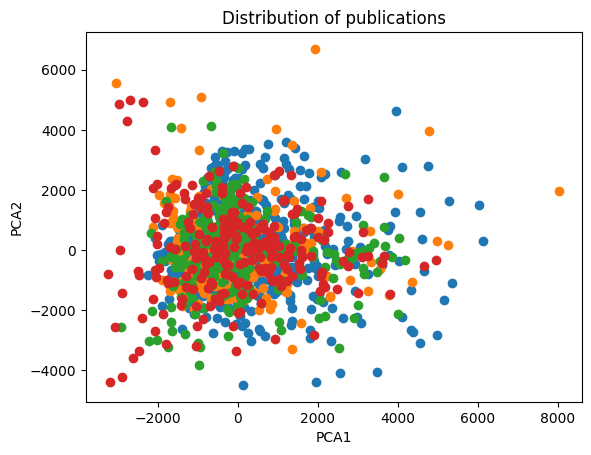

In [99]:
pca = PCA(n_components = 2)

class_one_idxs = np.argwhere(y_train == 0)
class_two_idxs = np.argwhere(y_train == 1)
class_three_idxs = np.argwhere(y_train == 2)
class_four_idxs = np.argwhere(y_train == 3)


class_one = X_train[class_one_idxs].squeeze()
class_two = X_train[class_two_idxs].squeeze()
class_three = X_train[class_three_idxs].squeeze()
class_four = X_train[class_four_idxs].squeeze()


class_one_2d = pca.fit_transform(class_one)
class_two_2d = pca.fit_transform(class_two)
class_three_2d = pca.fit_transform(class_three)
class_four_2d = pca.fit_transform(class_four)


plt.scatter(class_one_2d[:,0],class_one_2d[:,1],label = '0')
plt.scatter(class_two_2d[:,0],class_two_2d[:,1],label = '1')
plt.scatter(class_three_2d[:,0],class_three_2d[:,1],label = '2')
plt.scatter(class_four_2d[:,0],class_four_2d[:,1],label = '3')
plt.title('Distribution of publications')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

In [100]:
vocab_size = len(vocab.word_index) + 1
embedding_size = 164
hidden_size = 128
n_classes = len(eda.unique_values(target_feature))

model_rnn = Publication_rnn(vocab_size,embedding_size,hidden_size,n_classes)
model_lstm = Publication_lstm(vocab_size,embedding_size,hidden_size,n_classes)

Unique values of publication: [0 1 2 3]


In [101]:
lr = 0.0001
batch_size = 32
epochs = 30

Trainer_rnn = Train_Model(model_rnn,lr,batch_size,epochs)
Trainer_lstm = Train_Model(model_lstm,lr,batch_size,epochs)

print(f'RNN model: ')
model_rnn = Trainer_rnn.fit(X_train,y_train)
Trainer_rnn.eval(X_test,y_test)

print(f'LSTM model: ')
model_lstm = Trainer_lstm.fit(X_train,y_train)
Trainer_lstm.eval(X_test,y_test)

RNN model: 
Metrics on Train Data:
Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'flatten_4' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.1972 - loss: 1.6193
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.4743 - loss: 1.2731
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.4648 - loss: 1.2704
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5189 - loss: 1.1949
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5975 - loss: 1.0238
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7175 - loss: 0.8315
Epoch 7/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8566 - loss: 0.6583
Epoch 8/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9244 - loss: 0.5654
Epoch 9/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9692 - loss: 0.4474
Epoch 10/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9630 - loss: 0.4133
Epoch 11/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9839 - loss: 0.3453
Epoch 12/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9831 - l

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'flatten_5' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - accuracy: 0.4839 - loss: 1.3064
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.4917 - loss: 1.2407
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.5294 - loss: 1.0887
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.6485 - loss: 0.8848
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.7262 - loss: 0.7525
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.7988 - loss: 0.6387
Epoch 7/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.8074 - loss: 0.5499
Epoch 8/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.8223 - loss: 0.4916
Epoch 9/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.8395 - loss: 0.4393
Epoch 10/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.8422 - loss: 0.4240
Epoch 11/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9101 - loss: 0.3706
Epoch 12/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.93

In [104]:
review = df['text'].iloc[7]

Publication(model_rnn,review)

Review: 10 Subtle Strategies I Wish I Knew When I Had 23 Email Subscribers and Made $0 Onlinenan - Publication: Towards Data Science


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'flatten_4' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
